#### 1.


In [2]:
import pandas as pd
import openai
import sacrebleu
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
from collections import Counter
############ 1. Data Preparation for Model Training by Combine the datasets and prepare them for training ############
# Load cleaned Counsel-Chat dataset
counsel_chat_data = pd.read_csv(
    '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/counsel_chat_data_after_data_preparation.csv')
display(counsel_chat_data.info())
display(counsel_chat_data.head(4))
# Rename columns for consistency with previous combined data format
counsel_chat_data.rename(
    columns={'questionText': 'prompt', 'answerText': 'response'}, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1383 entries, 0 to 1382
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   questionID     1383 non-null   object
 1   questionTitle  1383 non-null   object
 2   questionText   1383 non-null   object
 3   questionUrl    1383 non-null   object
 4   topics         1376 non-null   object
 5   therapistName  1383 non-null   object
 6   therapistUrl   1383 non-null   object
 7   answerText     1383 non-null   object
 8   upvotes        1383 non-null   int64 
dtypes: int64(1), object(8)
memory usage: 97.4+ KB


None

,questionID,questionTitle,questionText,questionUrl,topics,therapistName,therapistUrl,answerText,upvotes
0,5566fab2a64752d71ec3ca69,Escalating disagreements between mother and wife,my wife and mother are having tense disagreeme...,https://counselchat.com/questions/escalating-d...,Family Conflict,"Kristi King-Morgan, LMSW",https://counselchat.com/therapists/kristi-king...,<p>what you are describing is something psycho...,0
1,5566f94fa64752d71ec3ca64,I'm addicted to smoking. How can I stop?,"i'm planning to have baby, so i have to quit s...",https://counselchat.com/questions/i-m-addicted...,"Substance Abuse,Addiction",Rebecca Duellman,https://counselchat.com/therapists/rebecca-due...,<p>hi. good for you in planning ahead to do wh...,0
2,5567d26887a1cc0c3f3d8f46,Keeping secrets from my family,"i have secrets in my mind, and i don't know wh...",https://counselchat.com/questions/keeping-secr...,Family Conflict,Jeevna Bajaj,https://counselchat.com/therapists/jeevna-bajaj,<p>it sounds like keeping the secrets has beco...,0
3,556bed15c969ba5861709df5,The Underlying Causes of Being Possessive,i am extremely possessive in my relationships ...,https://counselchat.com/questions/the-underlyi...,"Behavioral Change,Social Relationships",Rebecca Duellman,https://counselchat.com/therapists/rebecca-due...,<p>hi there. it's great you are able to realiz...,0


#### 2.


In [3]:
############ 2. Generate Responses Using GPT-4 Model via OpenAI API ############

openai.api_key = 'sk-proj-6TLzq89EwvduXuziOOVDT3BlbkFJ1TqCRGrTSdnVF1oDysKl'


def generate_responses(data, model_name='gpt-4-turbo'):
    responses = []

    for index, row in data.iterrows():
        prompt = row['prompt']
        try:
            response = openai.ChatCompletion.create(
                model=model_name,
                messages=[
                    {"role": "system", "content": "You are a mental health counselor. Your goal is to provide empathetic, supportive, and reflective responses to clients' questions. Focus on understanding the clients' concerns and offering thoughtful and compassionate guidance."},
                    {"role": "user", "content": prompt}
                ],
                max_tokens=150,
                temperature=0.7
            )
            responses.append(response.choices[0].message['content'].strip())
        except Exception as e:
            print(f"Error generating response for index {index}: {e}")
            responses.append("")

    data['generated_response'] = responses
    data.to_csv('/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/v3/generated_responses.csv', index=False)
    return data


# Generate responses for the dataset
counsel_chat_data = generate_responses(counsel_chat_data)

Error generating response for index 745: HTTP code 502 from API (<html>
<head><title>502 Bad Gateway</title></head>
<body>
<center><h1>502 Bad Gateway</h1></center>
<hr><center>cloudflare</center>
</body>
</html>
)


#### 3.


In [1]:
############ 2. Evaluation of Generated Responses ############
import pandas as pd
import openai
import sacrebleu
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
from collections import Counter
def evaluate_responses(data):
    bleu_scores = []
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    for index, row in data.iterrows():
        reference = row['response']
        hypothesis = row['generated_response']

        try:
            # BLEU Score
            bleu_score = sacrebleu.sentence_bleu(
                hypothesis, [reference]).score / 100  # Normalize BLEU score
            bleu_scores.append(bleu_score)

            # ROUGE Score
            scorer = rouge_scorer.RougeScorer(
                ['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
            scores = scorer.score(reference, hypothesis)
            for key in scores:
                rouge_scores[key].append(scores[key].fmeasure)

            print(f"Processed index {index}: BLEU = {bleu_score}, ROUGE-1 = {scores['rouge1'].fmeasure}, ROUGE-2 = {
                  scores['rouge2'].fmeasure}, ROUGE-L = {scores['rougeL'].fmeasure}")

        except Exception as e:
            print(f"Error processing index {index}: {e}")

    evaluation_results = {
        'bleu': sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0,
        'rouge1': sum(rouge_scores['rouge1']) / len(rouge_scores['rouge1']) if rouge_scores['rouge1'] else 0,
        'rouge2': sum(rouge_scores['rouge2']) / len(rouge_scores['rouge2']) if rouge_scores['rouge2'] else 0,
        'rougeL': sum(rouge_scores['rougeL']) / len(rouge_scores['rougeL']) if rouge_scores['rougeL'] else 0
    }

    return evaluation_results


# Evaluate the model
counsel_chat_data = pd.read_csv(
    '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/v3/generated_responses.csv')
evaluation_results = evaluate_responses(counsel_chat_data)

print("Evaluation Results:", evaluation_results)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Processed index 0: BLEU = 0.002307646849309562, ROUGE-1 = 0.25798212005108556, ROUGE-2 = 0.08194622279129321, ROUGE-L = 0.12005108556832693
Processed index 1: BLEU = 0.003408491376222433, ROUGE-1 = 0.3031578947368421, ROUGE-2 = 0.06342494714587738, ROUGE-L = 0.1473684210526316
Processed index 2: BLEU = 0.02010498636129067, ROUGE-1 = 0.41666666666666663, ROUGE-2 = 0.07784431137724551, ROUGE-L = 0.20238095238095238
Processed index 3: BLEU = 0.009201027394288894, ROUGE-1 = 0.24324324324324323, ROUG

#### 4.


Data loaded successfully. Total records: 1383


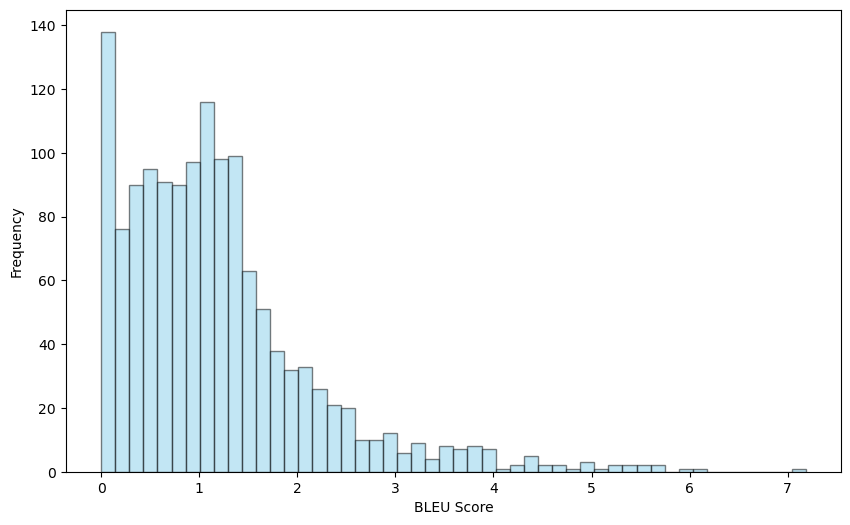

In [2]:
############ 3. Analyze BLEU Score Distribution ############

def calculate_bleu_scores(data):
    bleu_scores = []
    try:
        print(f"Data loaded successfully. Total records: {len(data)}")
    except Exception as e:
        print(f"Error loading data: {e}")

    for index, row in data.iterrows():
        reference = row['response']
        hypothesis = row['generated_response']
        bleu_score = sacrebleu.sentence_bleu(hypothesis, [reference]).score
        bleu_scores.append(bleu_score)

    data['bleu_score'] = bleu_scores
    return data


counsel_chat_data = pd.read_csv(
    '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/v3/generated_responses.csv')
evaluated_data = calculate_bleu_scores(counsel_chat_data)

# Plot Distribution:
plt.figure(figsize=(10, 6))
plt.hist(evaluated_data['bleu_score'], bins=50,
         color='skyblue', edgecolor='black', alpha=0.5)
#plt.title('Distribution of BLEU Scores')
plt.xlabel('BLEU Score')
plt.ylabel('Frequency')
plt.savefig('/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/v3/gpt_4_turbo_bleu_score_distribution.eps', format='eps', dpi=600)
plt.show()

#### 5.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1383 entries, 0 to 1382
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   questionID          1383 non-null   object 
 1   questionTitle       1383 non-null   object 
 2   prompt              1383 non-null   object 
 3   questionUrl         1383 non-null   object 
 4   topics              1376 non-null   object 
 5   therapistName       1383 non-null   object 
 6   therapistUrl        1383 non-null   object 
 7   response            1383 non-null   object 
 8   upvotes             1383 non-null   int64  
 9   generated_response  1383 non-null   object 
 10  bleu_score          1383 non-null   float64
dtypes: float64(1), int64(1), object(9)
memory usage: 119.0+ KB
None


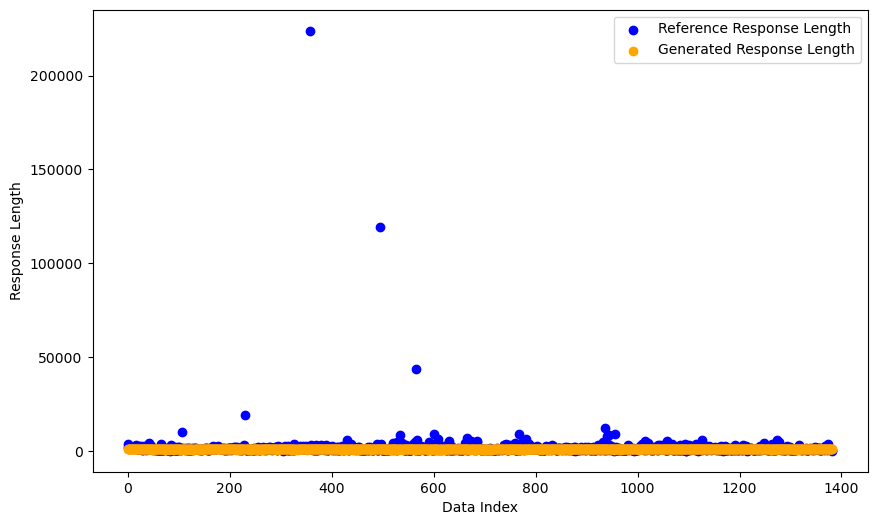

Most common words in generated responses:
to: 7399
and: 6419
your: 4721
a: 4557
you: 3718
the: 3351
of: 2697
can: 2683
that: 2576
be: 2539
with: 1946
in: 1908
or: 1771
might: 1718
It: 1652
like: 1567
about: 1532
you're: 1524
feelings: 1332
are: 1327


In [3]:
############ 4. Length Analysis of Generated Responses ############
print(evaluated_data.info())
evaluated_data['reference_length'] = evaluated_data['response'].apply(len)
evaluated_data['generated_length'] = evaluated_data['generated_response'].apply(
    len)

plt.figure(figsize=(10, 6))
plt.scatter(evaluated_data.index,
            evaluated_data['reference_length'], color='blue', label='Reference Response Length')
plt.scatter(evaluated_data.index,
            evaluated_data['generated_length'], color='orange', label='Generated Response Length')

plt.xlabel('Data Index')
plt.ylabel('Response Length')
#plt.title('Length Comparison of Reference and Generated Responses')
plt.legend()
plt.savefig('/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/v3/gpt_4_turbo_length_analysis.eps', format='eps', dpi=600)
plt.show()

############ 5. Content Analysis of Generated Responses ############

generated_responses = evaluated_data['generated_response'].tolist()
word_counts = Counter(" ".join(generated_responses).split())

common_words = word_counts.most_common(20)
print("Most common words in generated responses:")
for word, count in common_words:
    print(f"{word}: {count}")

In [ ]:
Revised Article Sections:

Abstract: Include the sentiment analysis and emotion detection results, highlighting their importance in evaluating the emotional tone and specific emotions in the generated responses.

Introduction: Mention the addition of sentiment analysis and emotion detection as part of the evaluation process to better understand the emotional quality of the AI-generated responses.

Methods: Detail the implementation of sentiment analysis and emotion detection, including the libraries and methods used.

Results: Present the findings from the sentiment analysis and emotion detection, discussing how they complement the BLEU and ROUGE scores in assessing the quality of the generated responses.

Discussion: Reflect on the implications of the sentiment and emotion analysis results for the use of AI in mental health counseling. Discuss how these results align with the call for papers’ focus on clinically applicable and ethically sound AI research.

Limitations and Future Work: Acknowledge the limitations of the current study, such as the need for more nuanced measures of empathy and understanding beyond sentiment and emotion analysis. Suggest future research directions, including the development of models that can adapt to individual client needs and provide personalized responses.

Conclusion: Summarize the study’s findings, including the sentiment and emotion analysis results, and emphasize the potential of AI to support mental health counseling while highlighting the need for further research to enhance its effectiveness.

Ensure that all references and citations are correctly formatted according to the Nature Portfolio submission guidelines. By incorporating these changes, the article will be more comprehensive and aligned with the call for papers’ requirements. Remember to include a discussion on the ethical considerations of using AI in mental health care, as emphasized in the call for papers.

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/dipendrapant/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                  generated_response  sentiment    pos    neu  \
0  It sounds like you're in a challenging positio...   0.200000  0.175  0.788   
1  It's really commendable that you're thinking a...   0.039231  0.128  0.828   
2  It sounds like you're carrying a heavy burden,...   0.092857  0.103  0.759   
3  It sounds like you're already taking a signifi...   0.021656  0.142  0.701   
4  I'm sorry to hear about the challenges you've ...   0.026074  0.116  0.797   

     neg  compound  
0  0.037    0.9451  
1  0.044    0.8481  
2  0.138   -0.6458  
3  0.157   -0.4939  
4  0.087    0.6142  
Overall Sentiment Score: 0.12360066968528857
Average Emotion Scores:
pos         0.180487
neu         0.739387
neg         0.080142
compound    0.623066
dtype: float64


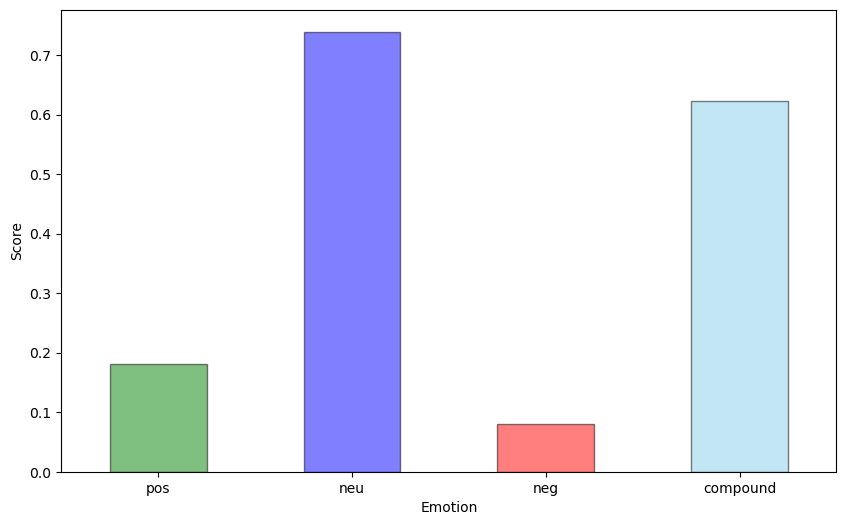

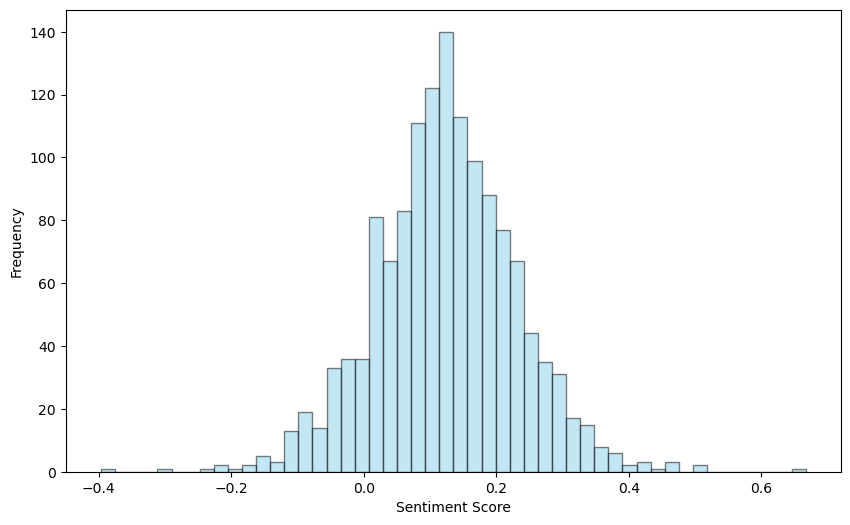

In [19]:
from textblob import TextBlob
import pandas as pd
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

############ 6. Sentiment Analysis and Emotion Detection ############

# Function to perform sentiment analysis


def analyze_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Function to perform emotion detection


def detect_emotions(text):
    sid = SentimentIntensityAnalyzer()
    return sid.polarity_scores(text)

# Adding sentiment analysis and emotion detection to the evaluation


def evaluate_responses_with_sentiment(data):
    # Perform sentiment analysis
    data['sentiment'] = data['generated_response'].apply(
        lambda x: analyze_sentiment(x))

    # Perform emotion detection
    emotion_scores = data['generated_response'].apply(
        lambda x: detect_emotions(x))
    data = pd.concat([data, emotion_scores.apply(pd.Series)], axis=1)

    return data


# Apply the extended evaluation function
evaluated_data = pd.read_csv(
    '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/v3/generated_responses.csv')
evaluated_data_with_sentiment = evaluate_responses_with_sentiment(
    evaluated_data)

# Display some sentiment and emotion analysis results
print(evaluated_data_with_sentiment[[
      'generated_response', 'sentiment', 'pos', 'neu', 'neg', 'compound']].head())

############ 7. Summarize Sentiment and Emotion Scores ############

# Calculate overall sentiment score
overall_sentiment = evaluated_data_with_sentiment['sentiment'].mean()
print(f"Overall Sentiment Score: {overall_sentiment}")

# Calculate average emotion scores
average_emotions = evaluated_data_with_sentiment[[
    'pos', 'neu', 'neg', 'compound']].mean()
print(f"Average Emotion Scores:\n{average_emotions}")

# Plotting the emotion distributions
plt.figure(figsize=(10, 6))
average_emotions.plot(kind='bar', color=[
                      'green', 'blue', 'red', 'skyblue'], edgecolor='black', alpha=0.5)
#plt.title('Average Emotion Scores')
plt.ylabel('Score')
plt.xlabel('Emotion')
plt.xticks(rotation=0)
plt.savefig('/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/v3/gpt_4_turbo_emotion_scores.eps', format='eps', dpi=600)
plt.show()

############ 8. Plot Histogram of Sentiment Scores ############

# Plot the histogram of sentiment scores
plt.figure(figsize=(10, 6))
plt.hist(evaluated_data_with_sentiment['sentiment'],
         bins=50, color='skyblue', edgecolor='black', alpha=0.5)
#plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.savefig('/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/v3/gpt_4_turbo_sentiment_score_distribution.eps', format='eps', dpi=600)
plt.show()

In [6]:
import openai

# Set your API key
openai.api_key = 'sk-proj-6TLzq89EwvduXuziOOVDT3BlbkFJ1TqCRGrTSdnVF1oDysKl'

# Make a request to the API using the gpt-4-turbo model
response = openai.ChatCompletion.create(
    model="gpt-4-turbo",
    messages=[
        {"role": "system", "content": "You are a mental health counselor. Your goal is to provide empathetic, supportive, and reflective responses to clients' questions. Focus on understanding the clients' concerns and offering thoughtful and compassionate guidance."},
        {"role": "user", "content": "Tell me about GPT-4 turbo models."}
    ]
)

# Print the response
print(response.choices[0].message['content'])
model_used = response['model']
print(f"The model used is: {model_used}")

As of my last update, OpenAI had released the GPT-4 model, but there was no official release or detailed specification called "GPT-4 Turbo." It's possible that "Turbo" could refer to a specific configuration, optimization, or enhancement developed either by OpenAI or another entity to improve the functionality or performance characteristics of the standard GPT-4 model.

GPT-4 itself is an advanced version of the Generative Pre-trained Transformer models developed by OpenAI. It follows GPT-3 and exhibits more sophistication in understanding and generating human-like text based on a vast amount of data it was trained on. Some general features of GPT-4 might include:

1. **Improved Performance**: GPT-4 significantly enhances the accuracy and relevance of responses compared to its predecessors.

2. **Larger Context Window**: The ability to consider larger blocks of text for context, thereby generating more coherent and contextually appropriate responses.

3. **Robustness and Safety**: Enha